# Removal of artifacts from time series


In [102]:
import os
import sys
import importlib
from importlib import reload 
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display
import mplcursors
#import mpld3
from cycler import cycler

import scipy
import scipy.io as sio
from scipy import signal
from scipy.signal import spectrogram, hann, butter, filtfilt, freqz
from scipy import stats

import seaborn as sns
import pingouin as pg
import itertools
from itertools import combinations
from statannotations.Annotator import Annotator
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import FastICA

# import openpyxl
# from openpyxl import Workbook, load_workbook
# import xlrd
import pickle
import json
import csv

#mne
import mne_bids
import mne
from mne.time_frequency import tfr_morlet 
from mne.stats import permutation_cluster_test
from mne.preprocessing import ICA, create_ecg_epochs


# TODO: add README file: 
# pip install pingouin
# pip install statannotations
# pip install fooof
# pip install mpldatacursor

In [61]:
jennifer_user_path = os.getcwd()
while jennifer_user_path[-14:] != 'jenniferbehnke':
    jennifer_user_path = os.path.dirname(jennifer_user_path)

# directory to this Repository
project_path = os.path.join(jennifer_user_path, 'code', 'BetaSenSightLongterm', 'BetaSenSightLongterm')
sys.path.append(project_path)

os.chdir(project_path)

import src.bssu.utils.find_folders as find_folders
importlib.reload(find_folders)

# import PyPerceive

project_path = find_folders.chdir_repository("Py_Perceive")

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)

import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as PyPerceive_find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

# import meet

project_path = find_folders.chdir_repository("meet")

import meet as meet

# import all functions from BetaSenSightLongterm
project_path = find_folders.chdir_repository("BetaSenSightLongterm")

# tfr, processing
import src.bssu.tfr.BSSuPsd as BSSuPsd
import src.bssu.tfr.FastFourierPSD as FFpsd
import src.bssu.tfr.movement_artifact_cleaning as move_artifacts
import src.bssu.tfr.artifact_cleaning as artifacts

# bipolar Channel Analysis
import src.bssu.bipolar.power_spectra_plots as power_spectra_plots
import src.bssu.bipolar.PeakFrequencies_PSD as PeakFrequency_psd
import src.bssu.bipolar.BIP_channelGroups as BIP_channelGroups
import src.bssu.bipolar.BIP_perChannelAnalysis as BIP_perChannel


# monopolar Referencing
import src.bssu.monopolar.MonoRef_JLB as MonoRefJLB
import src.bssu.monopolar.GroupMonopolarPSD as groupMonopol
import src.bssu.monopolar.monoRef_weightPsdAverageByCoordinateDistance as MonoRefWeightedCoordinateDistance
import src.bssu.monopolar.externalized_lfp as externalized
import src.bssu.monopolar.monopol_method_comparison as monopol_comparison
import src.bssu.monopolar.bssu_contacts_maximal_beta as bssu_contacts
import src.bssu.monopolar.monoRef_Strelow as detec_strelow

# Ranking Order
import src.bssu.ranking.HighestRankedChannelPSD as highestRank
import src.bssu.ranking.monopolPSDaverage_withinSubject as PSDaverageMonopol
import src.bssu.ranking.BIPchannelGroups_ranks as BIP_ranks
import src.bssu.ranking.Permutation_rankings as Permute_ranks


# Clinical stimulation parameters
import src.bssu.stimulation.activeStimulationContacts as activeStimContacts

# utility functions
import src.bssu.utils.loadResults as loadResults
import src.bssu.utils.find_folders as find_folders
import src.bssu.utils.writeGroupDataframes as writeGroupDF
import src.bssu.utils.load_data_files as load_data
import src.bssu.utils.monopol_comparison_helpers as mono_comp_helpers

# import Classes
from src.bssu.classes import (metadataAnalysis_class, mainAnalysis_class, sessionAnalysis_class, 
                              channelAnalysis_class, featureAnalysis_class, frequencyBand_class)

# import mni coordinates
import src.bssu.mni.load_rotated_coordinates as load_mni


importlib.reload(BSSuPsd)
importlib.reload(MonoRefJLB)
importlib.reload(loadResults)
importlib.reload(highestRank)
importlib.reload(groupMonopol)
importlib.reload(PSDaverageMonopol)
importlib.reload(FFpsd)
importlib.reload(find_folders)
importlib.reload(metadataAnalysis_class)
importlib.reload(mainAnalysis_class)
importlib.reload(sessionAnalysis_class)
importlib.reload(channelAnalysis_class)
importlib.reload(featureAnalysis_class)
importlib.reload(frequencyBand_class)
importlib.reload(PeakFrequency_psd)
importlib.reload(power_spectra_plots)
importlib.reload(BIP_channelGroups)
importlib.reload(BIP_ranks)
importlib.reload(activeStimContacts)
importlib.reload(Permute_ranks)
importlib.reload(BIP_perChannel)
importlib.reload(load_mni)
importlib.reload(writeGroupDF)
importlib.reload(MonoRefWeightedCoordinateDistance)
importlib.reload(load_data)
importlib.reload(externalized)
importlib.reload(monopol_comparison)
importlib.reload(bssu_contacts)
importlib.reload(mono_comp_helpers)
importlib.reload(detec_strelow)
importlib.reload(move_artifacts)
importlib.reload(artifacts)

Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data


<module 'src.bssu.tfr.artifact_cleaning' from '/Users/jenniferbehnke/code/BetaSenSightLongterm/BetaSenSightLongterm/src/bssu/tfr/artifact_cleaning.py'>

In [5]:
# load if you want to see complete Dataframes
pd.set_option("display.max_rows", None)

In [8]:
# for interactive plots
# %matplotlib ipympl 

# for static plots
%matplotlib inline 


## Plot raw time series from each subject hemisphere, session and channel group in M0S0

In [58]:
time_series = artifacts.plot_raw_time_series(
    incl_sub=["024"],
    incl_session=["fu18m"],
    incl_condition=["m0s0"],
)

Load an MNE object

In [78]:
mne_object = artifacts.load_mne_object_pyPerceive(sub="024", session="fu18m", hemisphere="Left", channel_group="SegmIntraL")


	### WARNING: NaNs in Metadata Table sub-024 ###
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618063700.mat
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618064000.mat
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618064200.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084000.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084300.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084700.mat
NaNs in: sub024_ses-2021092106385396_run-BrainSense20210921070500.mat
NaNs in: sub024_ses-2021092106385396_run-BrainSense20210921072300.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921074800.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921080600.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921082400.mat
NaNs in: sub-20210615PStn_ses-2022061010445782_run-BrainSense20220610105800.mat
NaNs in: sub-20210615PStn_ses-2022061010445782_run-BrainSense20220610111500.mat
NaNs in: sub-2021061

FIT ICA
- n_components: if the artifact is strong, not many components needed
- include all EEG channels including those without ecg artifacts
- FastICA input must be 2D array: rows = time points, columns = channels

In [100]:
data = mne_object.get_data() # 2D shape (n_channels in rows, n_times in columns)

<Figure size 10000x2000 with 0 Axes>

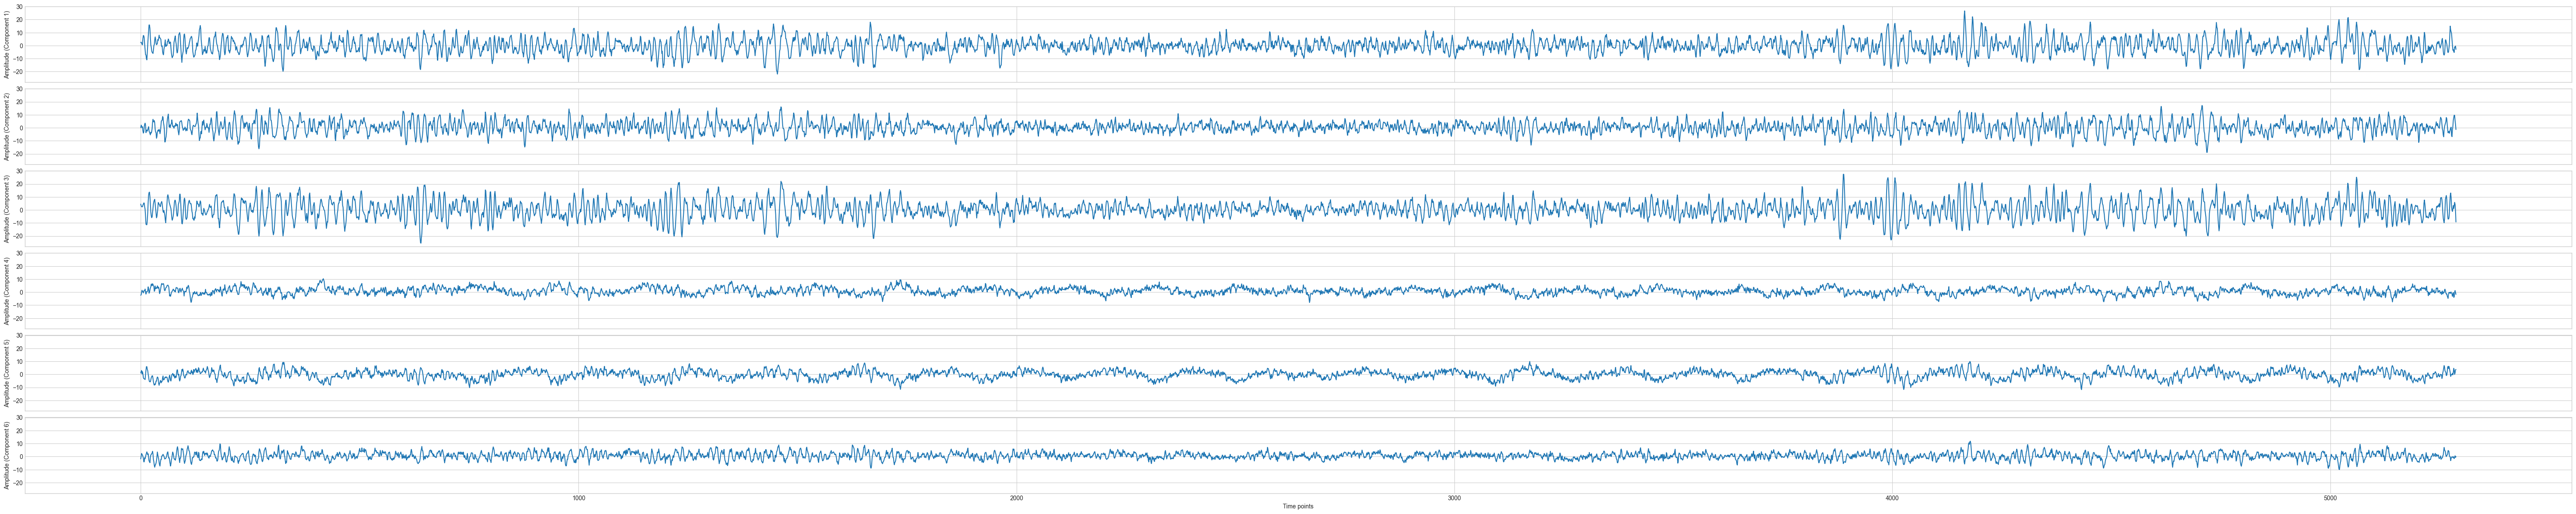

In [140]:
# plot the channels

time_points = np.arange(data.shape[1])
n_channels = data.shape[0]
plt.figure(figsize=(100, 20))

fig, axes = plt.subplots(n_channels, 1, figsize=(60, 2 * n_channels), sharex=True, sharey=True)

for i in range(n_channels):
    axes[i].plot(time_points, data[i], label=f'Channel {i + 1}')
    axes[i].set_ylabel(f'Amplitude (Component {i + 1})')

axes[n_channels - 1].set_xlabel('Time points')
plt.tight_layout()
plt.show()

In [117]:
# Step 1: Initialize ICA
n_components = 6
ica = FastICA(n_components=n_components, random_state=97)

# Fit ICA to your data
# ica.fit(data.T) # transposed data, because ICA expects shape (n_samples, n_features)
ica_components = ica.fit_transform(data.T)

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [126]:
data.shape

(6, 5288)

In [124]:
ica_components.shape

(5288, 6)

<Figure size 10000x2000 with 0 Axes>

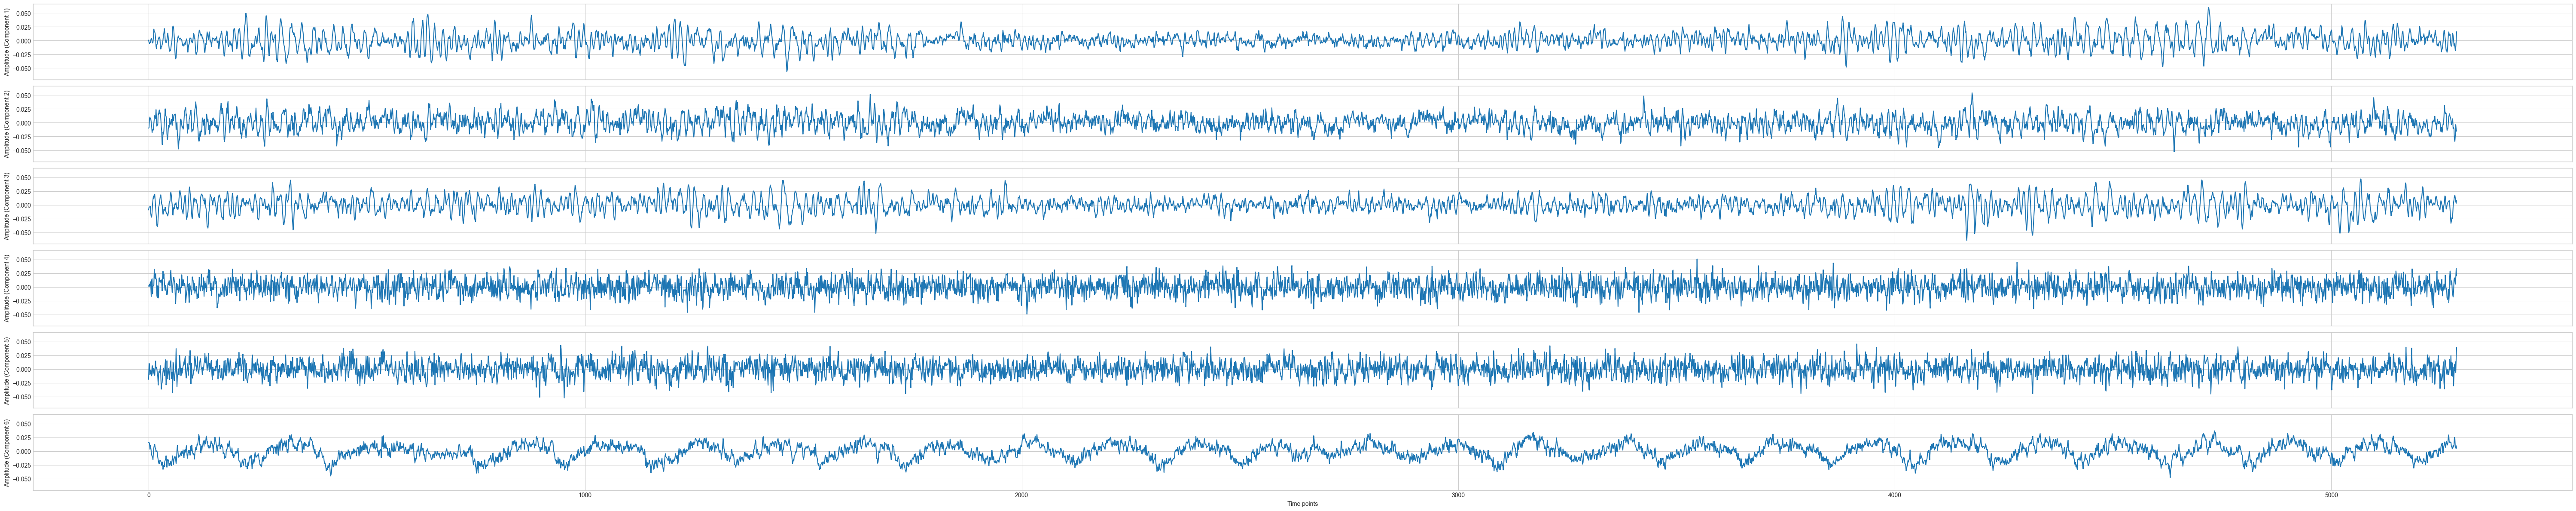

In [121]:
# Step 2: Visual inspection
# Plot the time courses of the components for visual inspection
time_points = np.arange(data.shape[1])  # Assuming your data is sampled uniformly
plt.figure(figsize=(100, 20))

fig, axes = plt.subplots(n_components, 1, figsize=(60, 2 * n_components), sharex=True, sharey=True)

for i in range(n_components):
    axes[i].plot(time_points, ica_components[:, i], label=f'Component {i + 1}')
    axes[i].set_ylabel(f'Amplitude (Component {i + 1})')

axes[n_components - 1].set_xlabel('Time points')
plt.tight_layout()
plt.show()

# for i in range(n_components):
#     plt.plot(time_points, ica_components[:, i], label=f'Component {i + 1}')

# plt.xlabel('Time points')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()

In [148]:
# Step 3: Identify the component representing ECG artifact (replace 5 with the actual index)
ecg_component_index = 5
ecg_component = ica_components[:, ecg_component_index]

# Step 3: Remove ECG artifact contribution from the initial EEG data

# try different scaling of the ECG component 
scaled_ecg_component = 0.5 * ecg_component
cleaned_ieeg_data = data.T - np.outer(scaled_ecg_component, ica.mixing_[:, ecg_component_index]) # both shape times x channels

# Now, cleaned_ieeg_data contains the EEG data with the ECG artifact removed
# Note: Depending on the scaling of the components, you might need to adjust the amplitude of the subtracted signal to achieve the desired artifact removal. 
# You may also need to experiment with the sign of the subtracted signal. 
# If the artifact is not completely removed, you can try multiplying the ECG component by a scaling factor before subtraction.


In [146]:
cleaned_ieeg_data.shape

(5288, 6)

<Figure size 10000x2000 with 0 Axes>

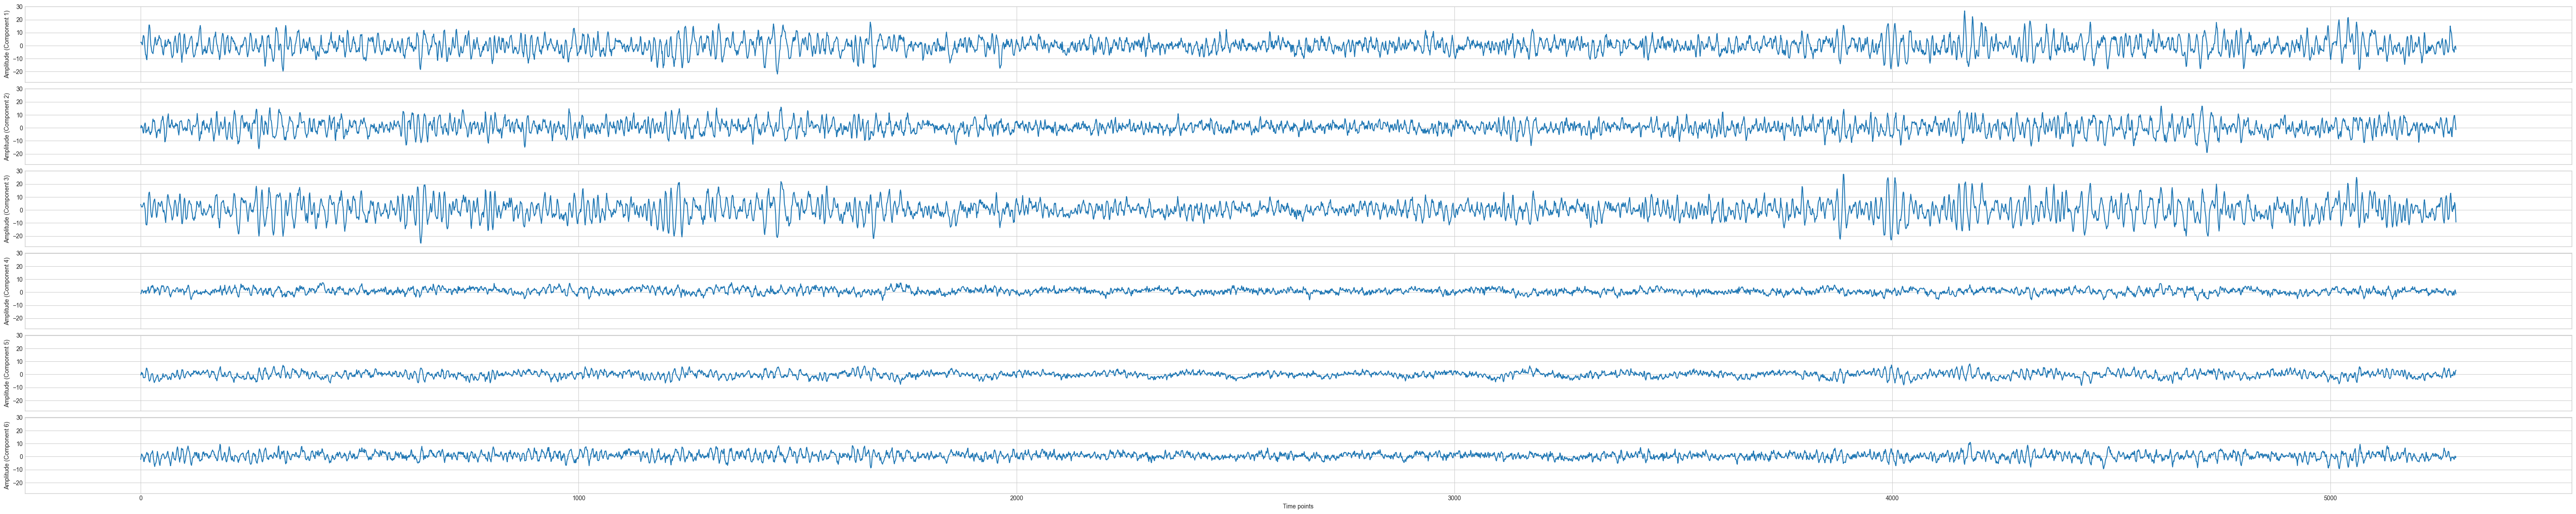

In [149]:
# plot the cleaned channels

cleaned_ieeg_data_transposed = cleaned_ieeg_data.T

time_points = np.arange(cleaned_ieeg_data_transposed.shape[1])
n_channels = cleaned_ieeg_data_transposed.shape[0]
plt.figure(figsize=(100, 20))

fig, axes = plt.subplots(n_channels, 1, figsize=(60, 2 * n_channels), sharex=True, sharey=True)

for i in range(n_channels):
    axes[i].plot(time_points, cleaned_ieeg_data_transposed[i], label=f'Channel {i + 1}')
    axes[i].set_ylabel(f'Amplitude (Component {i + 1})')

axes[n_channels - 1].set_xlabel('Time points')
plt.tight_layout()
plt.show()

Using MNE ICA: first re-create the raw MNE objects in PyPerceive and add the info chs kind: "dbs" or "ieeg"
- without a channel type ICA won't work

In [94]:
for chan in mne_object.info["chs"]:
    print(f"Channel Name: {chan['ch_name']}, Channel Type: {chan['kind']}")

Channel Name: LFP_L_1A1B_STN_MT, Channel Type: 502 (FIFFV_MISC_CH)
Channel Name: LFP_L_1B1C_STN_MT, Channel Type: 502 (FIFFV_MISC_CH)
Channel Name: LFP_L_1A1C_STN_MT, Channel Type: 502 (FIFFV_MISC_CH)
Channel Name: LFP_L_2A2B_STN_MT, Channel Type: 502 (FIFFV_MISC_CH)
Channel Name: LFP_L_2B2C_STN_MT, Channel Type: 502 (FIFFV_MISC_CH)
Channel Name: LFP_L_2A2C_STN_MT, Channel Type: 502 (FIFFV_MISC_CH)


In [97]:
mne_object.info["chs"]

[{'coord_frame': 0 (FIFFV_COORD_UNKNOWN),
  'cal': 1.0,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'loc': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]),
  'unit': 107 (FIFF_UNIT_V),
  'ch_name': 'LFP_L_1A1B_STN_MT',
  'logno': 1,
  'scanno': 1,
  'kind': 502 (FIFFV_MISC_CH),
  'coil_type': 0 (FIFFV_COIL_NONE)},
 {'coord_frame': 0 (FIFFV_COORD_UNKNOWN),
  'cal': 1.0,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'loc': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]),
  'unit': 107 (FIFF_UNIT_V),
  'ch_name': 'LFP_L_1B1C_STN_MT',
  'logno': 2,
  'scanno': 2,
  'kind': 502 (FIFFV_MISC_CH),
  'coil_type': 0 (FIFFV_COIL_NONE)},
 {'coord_frame': 0 (FIFFV_COORD_UNKNOWN),
  'cal': 1.0,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'loc': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]),
  'unit': 107 (FIFF_UNIT_V),
  'ch_name': 'LFP_L_1A1C_STN_MT',
  'logno': 3,
  'scanno': 3,
  'kind': 502 (FIFFV_MISC_CH),
  'coil_type': 0 (FIFFV_COIL_NONE)},
 {'coord_frame': 0 (FIFFV_COORD_UNKNO

In [96]:
#picks = mne.pick_types(mne_object.info, eeg=True, meg=False, stim=False, eog=False, exclude=[])
all_picks = range(mne_object.info['nchan'])

ica = ICA(n_components=20, random_state=97, max_iter="auto")
ica.fit(mne_object, picks=all_picks)

ValueError: Invalid channel type passed for ICA: ['misc'].Only the following types are supported: ('mag', 'grad', 'eeg', 'csd', 'seeg', 'ecog', 'dbs', 'hbo', 'hbr', 'fnirs_cw_amplitude', 'fnirs_fd_ac_amplitude', 'fnirs_fd_phase', 'fnirs_od', 'eog')

In [ ]:
ica.plot_components()
plt.show()

ica.exclude = [ecg_component_index]  # Replace with the index of the ECG component
cleaned_data = ica.apply(raw_data)


plt.plot(cleaned_data[0])  # Replace 0 with the appropriate channel index
plt.title('Cleaned Data without ECG Artifact')
plt.show()


In [49]:
load_movement_artifact_table = loadResults.load_preprocessing_files(
    signal_filter="band-pass", table="movement_artifact_coord"
)

In [50]:
table = load_movement_artifact_table
table

subject hemisphere session channel_group  \
024_Right_fu3m_ring_m0s0           024      Right    fu3m          ring   
024_Right_fu3m_segm_intra_m0s0     024      Right    fu3m    segm_intra   
024_Right_fu3m_segm_inter_m0s0     024      Right    fu3m    segm_inter   
024_Left_fu3m_ring_m0s0            024       Left    fu3m          ring   
024_Left_fu3m_segm_intra_m0s0      024       Left    fu3m    segm_intra   
024_Left_fu3m_segm_inter_m0s0      024       Left    fu3m    segm_inter   

                               condition number_move_artifacts  \
024_Right_fu3m_ring_m0s0            m0s0                     0   
024_Right_fu3m_segm_intra_m0s0      m0s0                   1.0   
024_Right_fu3m_segm_inter_m0s0      m0s0                   1.0   
024_Left_fu3m_ring_m0s0             m0s0                     0   
024_Left_fu3m_segm_intra_m0s0       m0s0                     0   
024_Left_fu3m_segm_inter_m0s0       m0s0                     0   

                                                            artifact_x  \
024_Right_fu3m_ring_m0s0                                             0   
024_Right_fu3m_segm_intra_m0s0  [4664.043140765688, 4789.416189828562]   
024_Right_fu3m_segm_inter_m0s0  [500.3695080912744, 631.5713249732619]   
024_Left_fu3m_ring_m0s0                                              0   
024_Left_fu3m_segm_intra_m0s0                                        0   
024_Left_fu3m_segm_inter_m0s0                                        0   

                                                                artifact_y  \
024_Right_fu3m_ring_m0s0                                                 0   
024_Right_fu3m_segm_intra_m0s0  [-1.0195879785591728, -0.7867351600173578]   
024_Right_fu3m_segm_inter_m0s0  [0.047129538429942386, 0.1542298539607998]   
024_Left_fu3m_ring_m0s0                                                  0   
024_Left_fu3m_segm_intra_m0s0                                            0   
024_Left_fu3m_segm_inter_m0s0                                            0   

                               subject_hemisphere  
024_Right_fu3m_ring_m0s0                024_Right  
024_Right_fu3m_segm_intra_m0s0          024_Right  
024_Right_fu3m_segm_inter_m0s0          024_Right  
024_Left_fu3m_ring_m0s0                  024_Left  
024_Left_fu3m_segm_intra_m0s0            024_Left  
024_Left_fu3m_segm_inter_m0s0            024_Left

In [66]:
clean_power_spectra_table = loadResults.load_preprocessing_files(
    table="cleaned_power_spectra"
)

clean_power_spectra_table

subject_hemisphere session  \
024_Right_fu3m_RingR_LFP_R_03_STN_MT                 024_Right    fu3m   
024_Right_fu3m_RingR_LFP_R_13_STN_MT                 024_Right    fu3m   
024_Right_fu3m_RingR_LFP_R_02_STN_MT                 024_Right    fu3m   
024_Right_fu3m_RingR_LFP_R_12_STN_MT                 024_Right    fu3m   
024_Right_fu3m_RingR_LFP_R_01_STN_MT                 024_Right    fu3m   
024_Right_fu3m_RingR_LFP_R_23_STN_MT                 024_Right    fu3m   
024_Right_fu3m_SegmIntraR_LFP_R_1A1B_STN_MT          024_Right    fu3m   
024_Right_fu3m_SegmIntraR_LFP_R_1B1C_STN_MT          024_Right    fu3m   
024_Right_fu3m_SegmIntraR_LFP_R_1A1C_STN_MT          024_Right    fu3m   
024_Right_fu3m_SegmIntraR_LFP_R_2A2B_STN_MT          024_Right    fu3m   
024_Right_fu3m_SegmIntraR_LFP_R_2B2C_STN_MT          024_Right    fu3m   
024_Right_fu3m_SegmIntraR_LFP_R_2A2C_STN_MT          024_Right    fu3m   
024_Right_fu3m_SegmInterR_LFP_R_1A2A_STN_MT          024_Right    fu3m   
024_Right_fu3m_SegmInterR_LFP_R_1B2B_STN_MT          024_Right    fu3m   
024_Right_fu3m_SegmInterR_LFP_R_1C2C_STN_MT          024_Right    fu3m   
024_Left_fu3m_RingL_LFP_L_03_STN_MT                   024_Left    fu3m   
024_Left_fu3m_RingL_LFP_L_13_STN_MT                   024_Left    fu3m   
024_Left_fu3m_RingL_LFP_L_02_STN_MT                   024_Left    fu3m   
024_Left_fu3m_RingL_LFP_L_12_STN_MT                   024_Left    fu3m   
024_Left_fu3m_RingL_LFP_L_01_STN_MT                   024_Left    fu3m   
024_Left_fu3m_RingL_LFP_L_23_STN_MT                   024_Left    fu3m   
024_Left_fu3m_SegmIntraL_LFP_L_1A1B_STN_MT            024_Left    fu3m   
024_Left_fu3m_SegmIntraL_LFP_L_1B1C_STN_MT            024_Left    fu3m   
024_Left_fu3m_SegmIntraL_LFP_L_1A1C_STN_MT            024_Left    fu3m   
024_Left_fu3m_SegmIntraL_LFP_L_2A2B_STN_MT            024_Left    fu3m   
024_Left_fu3m_SegmIntraL_LFP_L_2B2C_STN_MT            024_Left    fu3m   
024_Left_fu3m_SegmIntraL_LFP_L_2A2C_STN_MT            024_Left    fu3m   
024_Left_fu3m_SegmInterL_LFP_L_1A2A_STN_MT            024_Left    fu3m   
024_Left_fu3m_SegmInterL_LFP_L_1B2B_STN_MT            024_Left    fu3m   
024_Left_fu3m_SegmInterL_LFP_L_1C2C_STN_MT            024_Left    fu3m   

                                            channel_group channel  \
024_Right_fu3m_RingR_LFP_R_03_STN_MT                 ring      03   
024_Right_fu3m_RingR_LFP_R_13_STN_MT                 ring      13   
024_Right_fu3m_RingR_LFP_R_02_STN_MT                 ring      02   
024_Right_fu3m_RingR_LFP_R_12_STN_MT                 ring      12   
024_Right_fu3m_RingR_LFP_R_01_STN_MT                 ring      01   
024_Right_fu3m_RingR_LFP_R_23_STN_MT                 ring      23   
024_Right_fu3m_SegmIntraR_LFP_R_1A1B_STN_MT    segm_intra    1A1B   
024_Right_fu3m_SegmIntraR_LFP_R_1B1C_STN_MT    segm_intra    1B1C   
024_Right_fu3m_SegmIntraR_LFP_R_1A1C_STN_MT    segm_intra    1A1C   
024_Right_fu3m_SegmIntraR_LFP_R_2A2B_STN_MT    segm_intra    2A2B   
024_Right_fu3m_SegmIntraR_LFP_R_2B2C_STN_MT    segm_intra    2B2C   
024_Right_fu3m_SegmIntraR_LFP_R_2A2C_STN_MT    segm_intra    2A2C   
024_Right_fu3m_SegmInterR_LFP_R_1A2A_STN_MT    segm_inter    1A2A   
024_Right_fu3m_SegmInterR_LFP_R_1B2B_STN_MT    segm_inter    1B2B   
024_Right_fu3m_SegmInterR_LFP_R_1C2C_STN_MT    segm_inter    1C2C   
024_Left_fu3m_RingL_LFP_L_03_STN_MT                  ring      03   
024_Left_fu3m_RingL_LFP_L_13_STN_MT                  ring      13   
024_Left_fu3m_RingL_LFP_L_02_STN_MT                  ring      02   
024_Left_fu3m_RingL_LFP_L_12_STN_MT                  ring      12   
024_Left_fu3m_RingL_LFP_L_01_STN_MT                  ring      01   
024_Left_fu3m_RingL_LFP_L_23_STN_MT                  ring      23   
024_Left_fu3m_SegmIntraL_LFP_L_1A1B_STN_MT     segm_intra    1A1B   
024_Left_fu3m_SegmIntraL_LFP_L_1B1C_STN_MT     segm_intra    1B1C   
024_Left_fu3m_SegmIntraL_LFP_L_1A1C_STN_MT     segm_intra    1A1C   
024_Left_fu3m_SegmIntraL

TypeError: 'Axes' object is not subscriptable

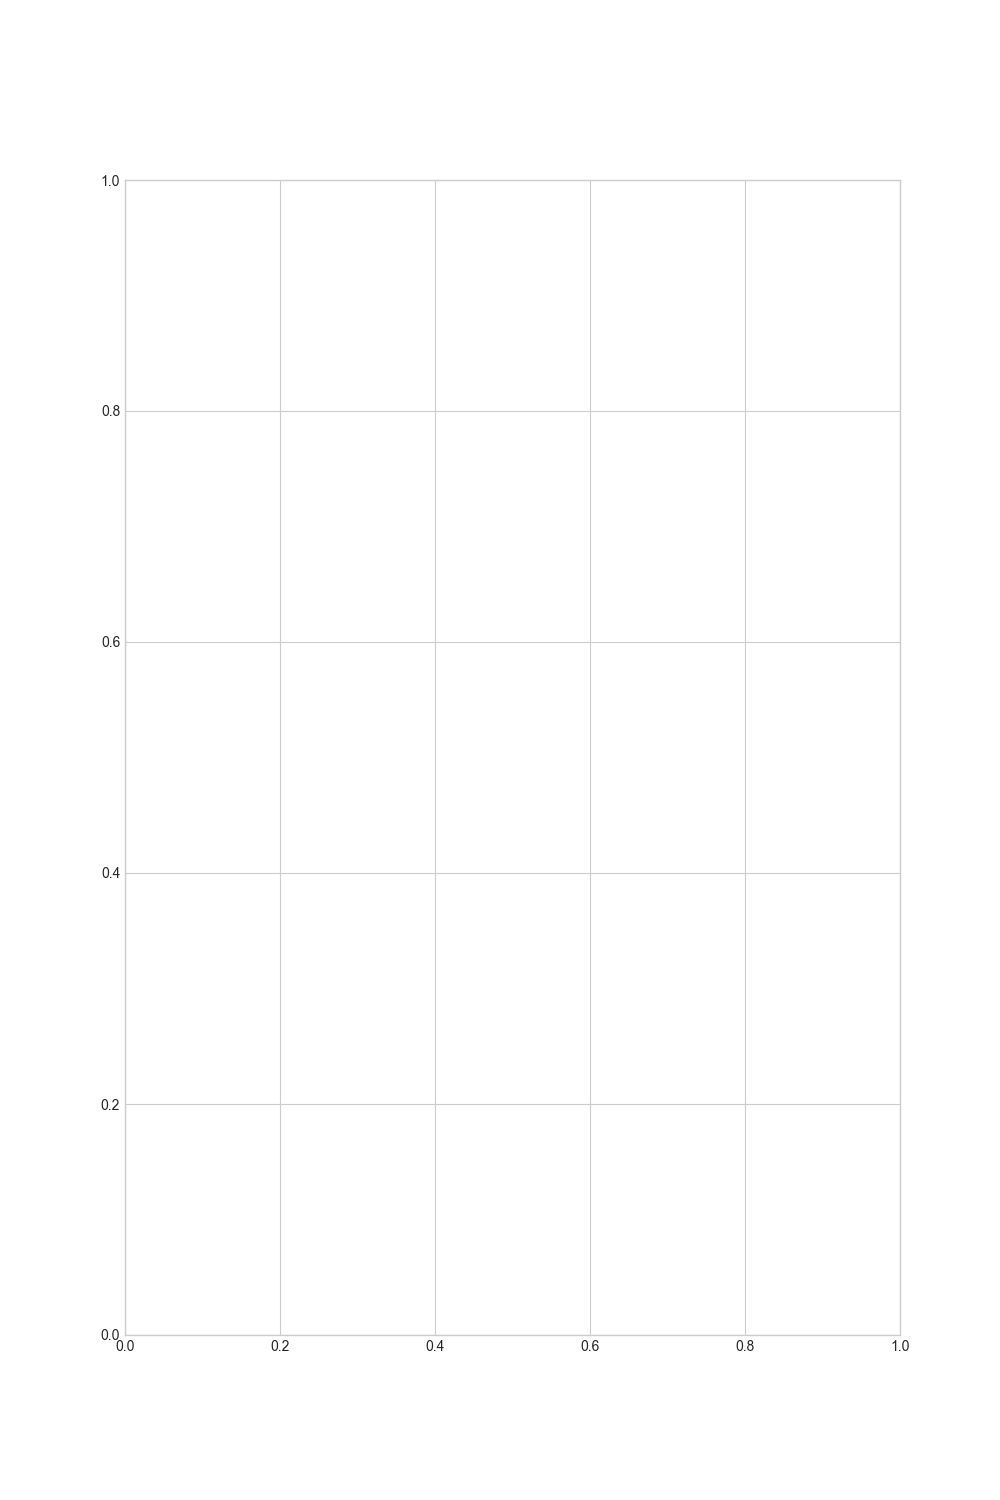

In [68]:
move_artifacts.plot_clean_power_spectra(signal_filter="band-pass")

In [18]:
hemisphere = "Right"

# depending on hemisphere: define incl_contact
incl_contact = {}
if hemisphere == "Right":
    incl_contact["Right"] = ["RingR", "SegmIntraR", "SegmInterR"]

elif hemisphere == "Left":
    incl_contact["Left"] = ["RingL", "SegmIntraL", "SegmInterL"]

mainclass_sub = main_class.PerceiveData(
        sub = "017", 
        incl_modalities= ["survey"],
        incl_session = ["fu3m"],
        incl_condition = ["m0s0"],
        incl_task = ["rest"],
        incl_contact=incl_contact[f"{hemisphere}"]
        )



	### WARNING: NaNs in Metadata Table sub-017 ###
NaNs in: sub-017_ses-2021040709594199_run-CHRONIC20210404124649.mat
NaNs in: sub-017_ses-2021040809491499_run-CHRONIC20210407065701.mat
NaNs in: sub-017_ses-2021041212054199_run-CHRONIC20210408063010.mat
NaNs in: sub-017_ses-2021041410364999_run-CHRONIC20210412103008.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414104500.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414104900.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414105100.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414105600.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414105900.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414110100.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414110400.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414110700.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414110800.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414111200.mat
NaNs in: sub-017_ses-2021041410364999_run-IS2021

In [19]:
for cont, contact in enumerate(incl_contact[f"{hemisphere}"]): 

    time_series = getattr(mainclass_sub.survey, "fu3m")

    #time_series = getattr(mainclass_sub, "m0s0")
    #time_series = getattr(mainclass_sub.rest, contact)
    #time_series = time_series.run1.data

In [20]:
data = time_series.m0s0.rest.RingR.run1.data

In [21]:
channel_1=data.get_data()[0, :]

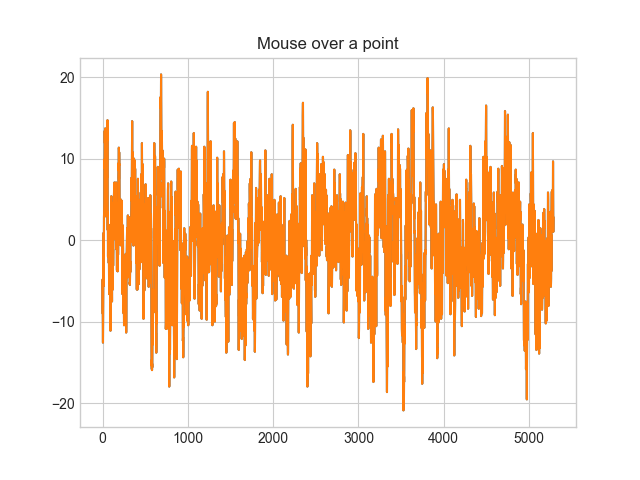

In [22]:
fig, ax = plt.subplots()
lines = ax.plot(channel_1)
ax.set_title("Mouse over a point")

ax.plot(channel_1)

x = np.arange(1, len(channel_1)+1)
y = channel_1

pos = []
def onclick(event):
    pos.append([event.xdata,event.ydata])
fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()

In [22]:
pos

[[3427.476239169029, 7.021813162771078],
 [4213.064747233546, 6.899119211193696]]


	### WARNING: NaNs in Metadata Table sub-024 ###
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618063700.mat
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618064000.mat
NaNs in: sub024_ses-2021061806255999_run-BrainSense20210618064200.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084000.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084300.mat
NaNs in: sub024_ses-2021061808253999_run-BrainSense20210618084700.mat
NaNs in: sub024_ses-2021092106385396_run-BrainSense20210921070500.mat
NaNs in: sub024_ses-2021092106385396_run-BrainSense20210921072300.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921074800.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921080600.mat
NaNs in: sub024_ses-2021092107452096_run-BrainSense20210921082400.mat
NaNs in: sub-20210615PStn_ses-2022061010445782_run-BrainSense20220610105800.mat
NaNs in: sub-20210615PStn_ses-2022061010445782_run-BrainSense20220610111500.mat
NaNs in: sub-2021061

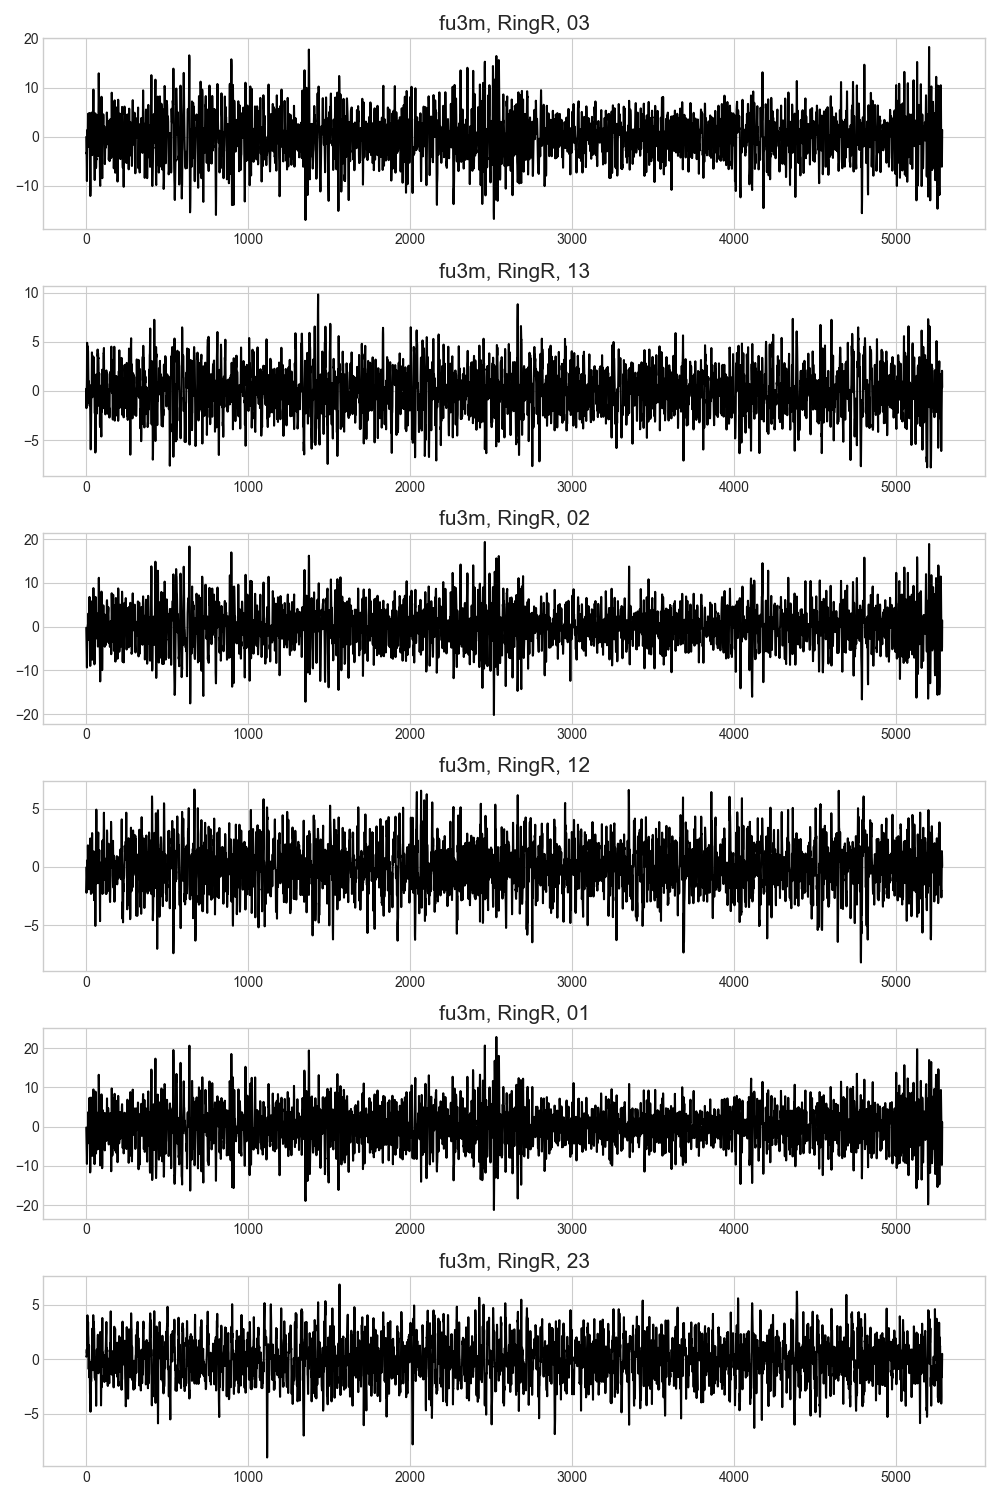

In [18]:
time_series = move_artifacts.plot_raw_time_series(
    incl_sub=["024", "025"],
    incl_session=["fu3m", "fu12m"],
    incl_condition=["m0s0"],
    filter="band-pass"
)

In [8]:
time_series["time_series"]

NameError: name 'time_series' is not defined

In [44]:
first = [x_list[0] for x_list in time_series["pos"]]
second = [y_list[1] for y_list in time_series["pos"]]

df = pd.DataFrame({"x": first, "y": second})
df

x         y
0  2376.071567  0.034472
1  3028.930793 -0.082913
2   424.321665  1.138427
3   711.447213  0.823755
4   777.692083 -0.680105
5  1220.435696 -0.143489

## Plot Time Frequency Plots of all subject hemispheres

In [7]:
plot_time_frequency = TF.time_frequency(
    incl_sub=["017"],
    incl_session=["postop", "fu3m", "fu12m", "fu18m"],
    incl_condition=["m0s0"],
    filter_signal="band-pass"
)


	### WARNING: NaNs in Metadata Table sub-017 ###
NaNs in: sub-017_ses-2021040709594199_run-CHRONIC20210404124649.mat
NaNs in: sub-017_ses-2021040809491499_run-CHRONIC20210407065701.mat
NaNs in: sub-017_ses-2021041212054199_run-CHRONIC20210408063010.mat
NaNs in: sub-017_ses-2021041410364999_run-CHRONIC20210412103008.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414104500.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414104900.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414105100.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414105600.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414105900.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414110100.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414110400.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414110700.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414110800.mat
NaNs in: sub-017_ses-2021041410364999_run-IS20210414111200.mat
NaNs in: sub-017_ses-2021041410364999_run-IS2021